# **Final Project Task 5 - Census Modeling NN Regression**

Requirements

- Create a NN regression model on the Census dataset, with 'hours-per-week' target

- Model Selection and Setup:
    - Build a neural network model using a deep learning library like TensorFlow, Keras or PyTorch.
    - Choose a loss (or experiment with different losses) for the model and justify the choice.
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons.


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation
    - Establish a Baseline Model:
        - Train a simple NN model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable.
    - Feature Selection:
        - Neural Networks can learn feature importance automatically, so all relevant features should be included rather than manually selecting a subset.
        - Consider using embeddings for high-cardinality categorical features instead of one-hot encoding to improve efficiency.
    - Experimentation:
        - Focus on preprocessing techniques rather than manually selecting feature combinations. Ensure numerical features are normalized (e.g., MinMaxScaler, StandardScaler) and categorical features are properly encoded (e.g., one-hot encoding or embeddings for high-cardinality variables).
        - Experiment with different neural network architectures (e.g., number of layers, neurons per layer) and hyperparameters (e.g., activation functions, learning rates, dropout rates, and batch sizes).
        - Use techniques such as early stopping and learning rate scheduling to optimize model performance and prevent overfitting.
        - Identify the best model which have the best performance metrics on test set.
    - Hyperparameter Tuning:
        - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments.
        - Consider using techniques like Grid Search for exhaustive tuning, Random Search for quicker exploration, or Bayesian Optimization for an intelligent, efficient search of hyperparameters.
        - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
        - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation
    - Evaluate models on the test dataset using regression metrics:
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - R² Score
    - Choose one metric for model comparison and explain your choice
    - Compare the results across different models. Save all experiment results into a table.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


## 1. Import Libraries and Load Data

The required libraries for neural network implementation, data processing, and visualization are imported. TensorFlow/Keras is used as the deep learning framework for building and training neural network models.

In [1]:
# Deep learning and data processing libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Data manipulation and numerical computation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# System and warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)




### Critical methodological note: Dataset selection for neural networks

**Why neural networks require Mixed Encoding:**

Task 1 created 3 preprocessed versions:
1. **Ordinal Encoding** (`census_data_preprocessed_full.csv`): For tree-based models
2. **Mixed Encoding** (`census_data_preprocessed_mixed.csv`): For neural networks and linear models
3. **One-Hot Encoding** (`census_data_preprocessed_onehot.csv`): For clustering (Task 4)

**Mixed Encoding combines:**
- **One-Hot** for low-cardinality categoricals (sex, race, relationship)
- **Target Encoding** for high-cardinality categoricals (occupation, country, workclass, marital-status)

**Why this is optimal for Neural Networks:**

Neural networks multiply inputs by weights in each layer:
```
layer_output = activation(weights * inputs + bias)
```

**Problem with Ordinal Encoding** (race=0,1,2,3,4):
- NN multiplies these arbitrary ordinal values by learned weights
- After multiplication and activation, false ordinal relationships influence predictions
- **Example**: If race=4 (Other) vs race=1 (Black), NN treats "4" as numerically larger, leading to false semantic meaning
- **Result**: Model learns artificial ordinal relationships for nominal variables

**Solution: Mixed Encoding:**

- **One-Hot** (sex, race, relationship): Each category gets independent weight, no false ordering relationships
- **Target** (occupation, country, workclass, marital-status): Continuous encoding capturing predictive relationships without dimensionality explosion

- **Standard practice**: One-Hot encoding is default for NN with nominal categorical variables
- **CRITICAL:** Task 1 already created train/test splits (80/20). This notebook uses the **same test set** as Task 3 to enable valid performance comparison between traditional ML and Neural Networks.



- **This notebook uses:** `census_data_preprocessed_mixed.csv` from Task 1, ensuring comparability with Task 3 traditional ML models.
---

### 1.1 Load preprocessed train/test splits




In [4]:
# Load preprocessed train/test splits from Task 1
# These splits ensure comparability with Task 3 traditional ML models
X_train_full = pd.read_csv('preprocessed_data/X_train.csv')
X_test = pd.read_csv('preprocessed_data/X_test.csv')
y_train_full = pd.read_csv('preprocessed_data/y_train.csv').values.ravel()
y_test = pd.read_csv('preprocessed_data/y_test.csv').values.ravel()

print("=== DATA LOADED FROM TASK 1 SPLITS ===")
print(f"Training set (full): {X_train_full.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Number of features: {X_train_full.shape[1]}")

print(f"\nTarget variable (hours-per-week) statistics:")
print(f"Train - Mean: {y_train_full.mean():.2f}, Std: {y_train_full.std():.2f}, Range: [{y_train_full.min():.0f}, {y_train_full.max():.0f}]")
print(f"Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}, Range: [{y_test.min():.0f}, {y_test.max():.0f}]")

print(f"\nFeature names ({X_train_full.shape[1]} total):")
print(X_train_full.columns.tolist())


=== DATA LOADED FROM TASK 1 SPLITS ===
Training set (full): 26,029 samples
Test set: 6,508 samples
Number of features: 18

Target variable (hours-per-week) statistics:
Train - Mean: 40.39, Std: 12.34, Range: [1, 99]
Test  - Mean: 40.63, Std: 12.37, Range: [1, 99]

Feature names (18 total):
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'age_group', 'total_capital', 'has_capital', 'education_squared', 'age_education_interaction', 'high_income']


---

### 1.2 Create validation split from training data

**IMPORTANT:** The test set is already fixed from Task 1 and will NOT be touched until final evaluation. We only split the training set into train (87.5%) and validation (12.5%), resulting in:

- **Training**: ~70% of original data (for model learning)
- **Validation**: ~10% of original data (for early stopping and hyperparameter monitoring)
- **Test**: 20% of original data (for final evaluation, same as Task 3)

This ensures direct performance comparison with traditional ML models from Task 3.

In [27]:
# Split training set into train (87.5%) and validation (12.5%)
# This creates: train=70%, val=10%, test=20% of original dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.125, random_state=42, shuffle=True
)

# Calculate total samples for percentage calculations
total_samples = len(X_train_full) + len(X_test)

print("=== FINAL DATA SPLIT SUMMARY ===")
print(f"Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/total_samples*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/total_samples*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({len(X_test)/total_samples*100:.1f}%)")
print(f"Total samples:  {total_samples:,}")

print(f"\nFeatures: {X_train.shape[1]}")
print(f"\nTarget variable (hours-per-week) distribution:")
print(f"Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Val   - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}")
print(f"Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

print("\nTest set is identical to Task 3 for valid performance comparison")

=== FINAL DATA SPLIT SUMMARY ===
Training set:   22,775 samples (70.0%)
Validation set: 3,254 samples (10.0%)
Test set:       6,508 samples (20.0%)
Total samples:  32,537

Features: 18

Target variable (hours-per-week) distribution:
Train - Mean: 40.40, Std: 12.38
Val   - Mean: 40.33, Std: 12.08
Test  - Mean: 40.63, Std: 12.37

Test set is identical to Task 3 for valid performance comparison


The validation set (12.5% of training data) monitors model performance during training through early stopping and learning rate scheduling, without touching the test set. The test set remains completely unseen until final evaluation, ensuring unbiased performance comparison with Task 3 traditional ML models.

### 2.1 Feature Scaling for Neural Networks

Neural networks require feature scaling for optimal convergence. MinMaxScaler transforms all features to [0, 1] range, ensuring each feature contributes equally to the learning process and preventing features with larger magnitudes from dominating gradients.

In [6]:
# Apply MinMaxScaler for neural network optimization
# Neural networks converge faster when inputs are in [0, 1] range
scaler = MinMaxScaler()

# Fit only on training data to prevent data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete")
print(f"Scaled training features shape: {X_train_scaled.shape}")
print(f"Feature range after scaling: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"Mean: {X_train_scaled.mean():.3f}, Std: {X_train_scaled.std():.3f}")

Feature scaling complete
Scaled training features shape: (22775, 18)
Feature range after scaling: [0.000, 1.000]
Mean: 0.387, Std: 0.363


MinMaxScaler normalizes each feature to [0, 1] range: `X_scaled = (X - X_min) / (X_max - X_min)`. This is optimal for neural networks because:

- **Prevents gradient domination**: All features contribute equally to weight updates- **Critical**: Scaler is fit ONLY on training data to prevent data leakage from validation/test sets

- **Accelerates convergence**: Similar feature scales enable consistent learning rates across parameters- **Stable activations**: Prevents saturation in sigmoid/tanh activations and enables effective ReLU training

## 3. Model Selection and Justification

Neural networks are selected for regression due to their ability to learn complex non-linear relationships. The architecture choices and loss functions are justified based on dataset characteristics and regression task requirements.

### 3.1 Loss Function Selection

**Loss Function:** Mean Squared Error (MSE)

**Justification:**
- MSE penalizes larger errors more heavily through squaring, making the model focus on reducing large deviations
- Provides smooth, continuous gradients for gradient descent optimization, enabling stable training
- Most commonly used loss function for regression tasks with continuous targets
- Differentiable everywhere, which is crucial for backpropagation in neural networks
- Target variable (hours-per-week) ranges from 1 to 99 hours with most values concentrated around 40 hours/week

- **MAE (Mean Absolute Error)**: More robust to outliers but provides less smooth gradients, potentially slower convergence
- **Huber Loss**: Combines benefits of MSE and MAE - quadratic for small errors, linear for large errors, good for datasets with extreme outliers
- **RMSE**: Not used as loss (same optimization as MSE) but used as evaluation metric in original units (hours)
- RMSE: Same as MSE but in original units (hours)

**Primary Evaluation Metric:** RMSE (Root Mean Squared Error)
- Interpretable in original units (hours per week)
- Standard metric for regression evaluation
- Allows direct comparison with traditional regression models from Task 3

### 3.2 Neural Network Architecture Justification

**Architecture Choices:**

**Pros of Neural Networks:**
- Automatic feature learning: Can discover complex non-linear patterns
- Universal approximation: Can approximate any continuous function
- No assumptions about data distribution required
- Handles high-dimensional data effectively
- Can learn interactions between features automatically

**Cons of Neural Networks:**
- Requires more data for optimal performance
- Computationally expensive to train
- Black box nature: Less interpretable than linear models
- Prone to overfitting without proper regularization
- Sensitive to hyperparameter choices
- Requires careful data preprocessing and normalization

**Why Neural Networks for Census Data:**
- Dataset size (22,775 training samples) is sufficient for neural network training
- Multiple features (18 features) with potential complex interactions between demographics
- Non-linear relationships expected between age, education, occupation, and working hours
- Neural networks can automatically learn feature interactions without manual feature engineering
- Mixed encoding (one-hot + target encoding) makes categorical features suitable for neural network processing
- Opportunity to compare neural network performance against traditional ML models from Task 3

## 4. Baseline Model

A simple baseline neural network is established with minimal architecture complexity. This provides a performance benchmark for comparing more sophisticated models.

### 4.1 Baseline model architecture

The baseline model uses a simple 2-hidden-layer architecture:
- **Input layer**: 18 features (from Mixed Encoding)
- **Hidden layer 1**: 64 neurons with ReLU activation
- **Hidden layer 2**: 32 neurons with ReLU activation
- **Output layer**: 1 neuron (linear activation for regression)

**Design choices:**

- No dropout or batch normalization to keep the baseline simple
- Decreasing layer sizes (64 to 32) create a funnel architecture for feature compression

- ReLU activation prevents vanishing gradients and enables faster training- Adam optimizer with learning rate 0.001 (commonly used default)

In [7]:
def create_baseline_model(input_dim):
    """
    Create a simple baseline neural network model.
    
    Architecture:
    - 2 hidden layers with ReLU activation
    - No regularization (dropout, batch norm)
    - Adam optimizer with default learning rate
    """
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim, name='hidden_1'),
        Dense(32, activation='relu', name='hidden_2'),
        Dense(1, name='output')  # Single output for regression
    ], name='Baseline_Model')
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    
    return model

# Create baseline model
baseline_model = create_baseline_model(X_train_scaled.shape[1])

# Display model architecture
print("Baseline model architecture")
baseline_model.summary()

# Calculate total parameters
total_params = baseline_model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")

Baseline model architecture


Model: "Baseline_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 64)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 3,329


The baseline model has a relatively small number of trainable parameters, making it computationally efficient while serving as a performance benchmark for more complex architectures.

### 4.2 Train Baseline Model

The baseline model is trained for up to 100 epochs with early stopping (patience=10) to prevent overfitting. Training and validation metrics (loss and RMSE) are monitored throughout to ensure proper convergence.

In [8]:
# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train baseline model
print("Training baseline model")
history_baseline = baseline_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

print(f"\nTraining completed. Best epoch: {early_stop.stopped_epoch - early_stop.patience + 1}")

Training baseline model
Restoring model weights from the end of the best epoch: 100.

Training completed. Best epoch: -9


Early stopping monitors validation loss and halts training when performance plateaus for 10 consecutive epochs, automatically preventing overfitting while saving computational resources. The best model weights are restored from the epoch with lowest validation loss.

### 4.3 Baseline Model Training History

Training curves visualize the learning progression over epochs. Convergence of train and validation curves indicates good model fit, while divergence signals overfitting (validation loss increases while training loss decreases).

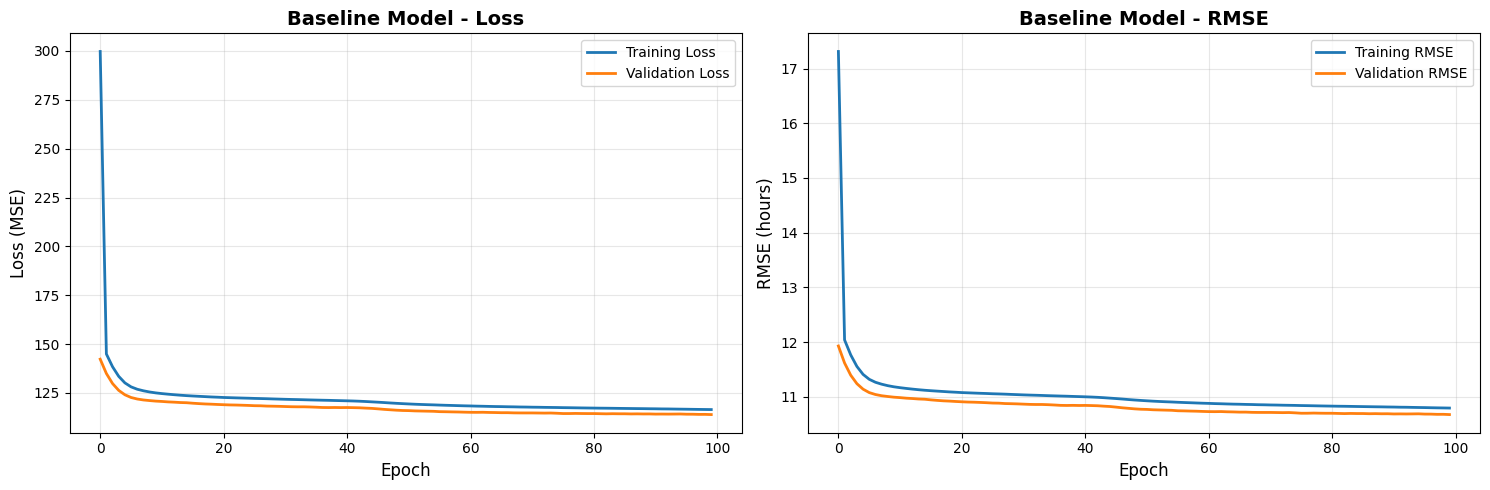

In [9]:
def plot_training_history(history, title):
    """
    Plot training and validation loss/metrics over epochs.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot RMSE metric
    axes[1].plot(history.history['rmse'], label='Training RMSE', linewidth=2)
    axes[1].plot(history.history['val_rmse'], label='Validation RMSE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('RMSE (hours)', fontsize=12)
    axes[1].set_title(f'{title} - RMSE', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot baseline training history
plot_training_history(history_baseline, 'Baseline Model')

The training curves show how loss and RMSE decrease over epochs. Convergence of training and validation curves indicates good generalization without overfitting.

### 4.4 Baseline Model Evaluation

The baseline model is evaluated on the test set (completely unseen during training) using comprehensive regression metrics. These results establish performance benchmarks for comparison with more sophisticated architectures.

In [25]:
def evaluate_model(model, X, y, model_name="Model"):
    """
    Evaluate model and return comprehensive metrics.
    """
    # Make predictions
    y_pred = model.predict(X, verbose=0).flatten()
    
    # Calculate metrics
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    print(f"\n{model_name} - Test set evaluation")
    print(f"Mean Absolute Error (MAE):  {mae:.4f} hours")
    print(f"Mean Squared Error (MSE):   {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f} hours")
    print(f"R^2 Score: {r2:.4f}")
    
    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

# Evaluate baseline model
baseline_results = evaluate_model(baseline_model, X_test_scaled, y_test, "Baseline Model")

# Store results for comparison
all_results = [baseline_results]


Baseline Model - Test set evaluation
Mean Absolute Error (MAE):  7.6403 hours
Mean Squared Error (MSE):   121.6721
Root Mean Squared Error (RMSE): 11.0305 hours
R^2 Score: 0.2045


The baseline model establishes initial performance benchmarks. RMSE (Root Mean Squared Error) indicates the average prediction error in hours, while R-squared Score measures the proportion of variance in working hours explained by the model (1.0 = perfect prediction, 0.0 = predicting mean value).

## 5. Model Experimentation

Multiple neural network architectures are experimented with to identify the optimal configuration. Experiments focus on varying depth, width, regularization techniques, and optimization strategies.

### 5.1 Experiment 1: Deeper network

A deeper architecture with 4 hidden layers is tested to explore whether additional depth can capture more complex patterns in the data.

=== DEEP MODEL ===


Model: "Deep_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 13,313 (52.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.


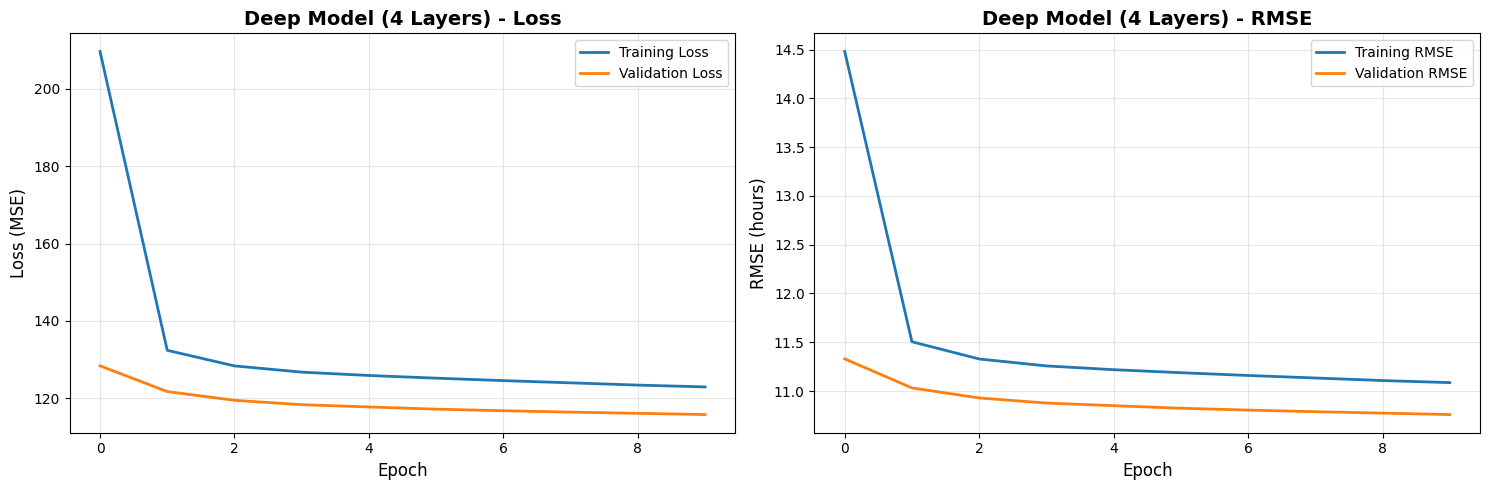


Deep Model (4 Layers) - Test set evaluation
Mean Absolute Error (MAE):  8.0209 hours
Mean Squared Error (MSE):   133.5312
Root Mean Squared Error (RMSE): 11.5556 hours
R² Score: 0.1270


In [11]:
def create_deep_model(input_dim):
    """Create a deeper neural network with 4 hidden layers."""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim, name='hidden_1'),
        Dense(64, activation='relu', name='hidden_2'),
        Dense(32, activation='relu', name='hidden_3'),
        Dense(16, activation='relu', name='hidden_4'),
        Dense(1, name='output')
    ], name='Deep_Model')
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse',
                  metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# Create and train
deep_model = create_deep_model(X_train_scaled.shape[1])
print("=== DEEP MODEL ===")
deep_model.summary()

history_deep = deep_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                               epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)
plot_training_history(history_deep, 'Deep Model (4 Layers)')
deep_results = evaluate_model(deep_model, X_test_scaled, y_test, "Deep Model (4 Layers)")
all_results.append(deep_results)

Deeper networks (4 layers) can learn hierarchical feature representations and more complex patterns, but risk overfitting if the dataset is insufficient or regularization is inadequate. The additional layers allow progressive feature abstraction from 128 to 64 to 32 to 16 neurons.

### 5.2 Experiment 2: Wider Network

A wider architecture with fewer layers but more neurons per layer is tested to compare depth versus width trade-offs.

=== WIDE MODEL ===


Model: "Wide_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 256)            │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,889 (148.00 KB)

 Trainable params: 37,889 (148.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.


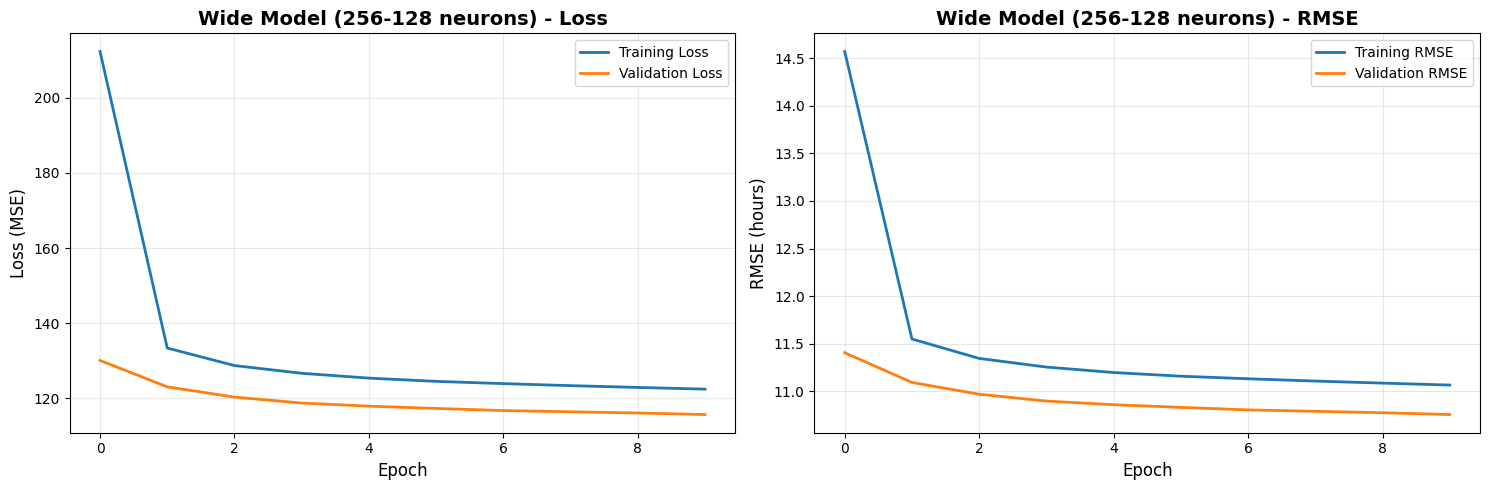


Wide Model (256-128) - Test set evaluation
Mean Absolute Error (MAE):  8.0781 hours
Mean Squared Error (MSE):   135.3164
Root Mean Squared Error (RMSE): 11.6326 hours
R² Score: 0.1153


In [12]:
def create_wide_model(input_dim):
    """Create a wider neural network with fewer but larger layers."""
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim, name='hidden_1'),
        Dense(128, activation='relu', name='hidden_2'),
        Dense(1, name='output')
    ], name='Wide_Model')
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse',
                  metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# Create and train
wide_model = create_wide_model(X_train_scaled.shape[1])
print("=== WIDE MODEL ===")
wide_model.summary()

history_wide = wide_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                               epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)
plot_training_history(history_wide, 'Wide Model (256-128 neurons)')
wide_results = evaluate_model(wide_model, X_test_scaled, y_test, "Wide Model (256-128)")
all_results.append(wide_results)

Wider networks (256-128 neurons) have more parameters per layer, enabling the model to learn richer feature representations and complex interactions in fewer layers. However, this increases model capacity and the risk of overfitting, especially with limited data.

### 5.3 Experiment 3: Regularized Model with Dropout

Dropout regularization is applied to prevent overfitting by randomly dropping neurons during training, forcing the network to learn more robust features.

=== DROPOUT MODEL ===


Model: "Dropout_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,801 (50.00 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.


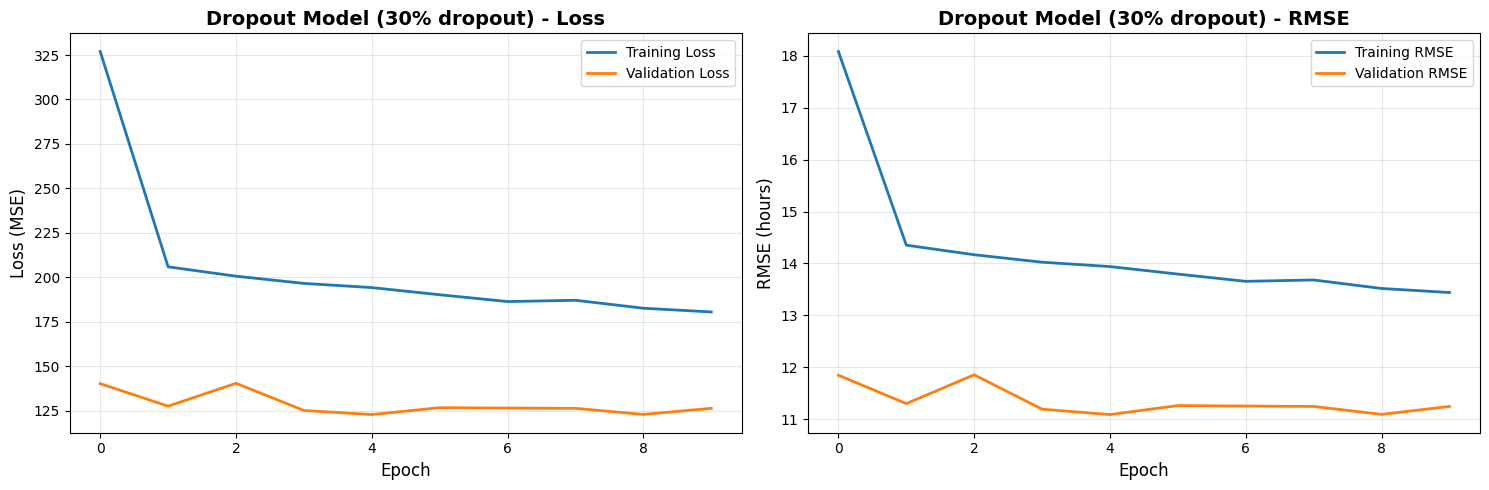


Dropout Model (30%) - Test set evaluation
Mean Absolute Error (MAE):  8.6044 hours
Mean Squared Error (MSE):   146.9556
Root Mean Squared Error (RMSE): 12.1225 hours
R² Score: 0.0393


In [13]:
def create_dropout_model(input_dim):
    """Create a neural network with dropout regularization."""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim, name='hidden_1'),
        Dropout(0.3, name='dropout_1'),
        Dense(64, activation='relu', name='hidden_2'),
        Dropout(0.3, name='dropout_2'),
        Dense(32, activation='relu', name='hidden_3'),
        Dropout(0.3, name='dropout_3'),
        Dense(1, name='output')
    ], name='Dropout_Model')
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse',
                  metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# Create and train
dropout_model = create_dropout_model(X_train_scaled.shape[1])
print("=== DROPOUT MODEL ===")
dropout_model.summary()

history_dropout = dropout_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                                    epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)
plot_training_history(history_dropout, 'Dropout Model (30% dropout)')
dropout_results = evaluate_model(dropout_model, X_test_scaled, y_test, "Dropout Model (30%)")
all_results.append(dropout_results)

Dropout randomly disables 30% of neurons during each training batch, preventing co-adaptation of neurons. This forces the network to learn redundant, distributed representations rather than relying on specific neurons, significantly improving generalization to unseen test data.

### 5.4 Experiment 4: Batch Normalization Model

Batch normalization is applied to normalize activations between layers, accelerating training and improving stability.

=== BATCH NORMALIZATION MODEL ===


Model: "BatchNorm_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,697 (53.50 KB)

 Trainable params: 13,249 (51.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.


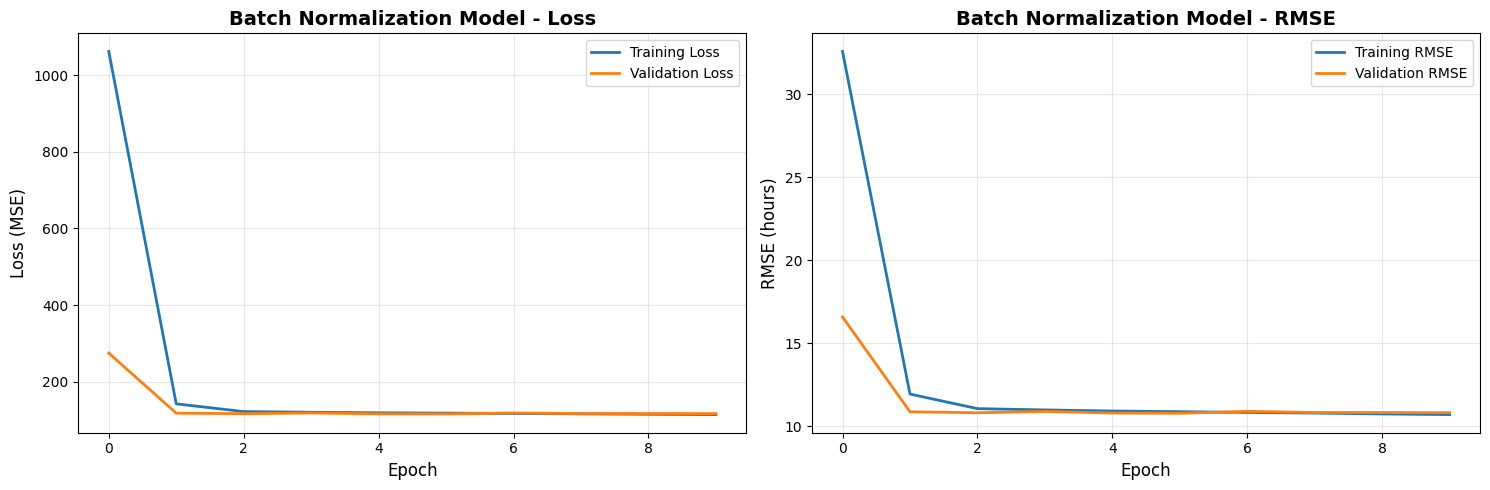


Batch Normalization Model - Test set evaluation
Mean Absolute Error (MAE):  13.8201 hours
Mean Squared Error (MSE):   286.3408
Root Mean Squared Error (RMSE): 16.9216 hours
R² Score: -0.8720


In [14]:
def create_batchnorm_model(input_dim):
    """Create a neural network with batch normalization."""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim, name='hidden_1'),
        BatchNormalization(name='bn_1'),
        Dense(64, activation='relu', name='hidden_2'),
        BatchNormalization(name='bn_2'),
        Dense(32, activation='relu', name='hidden_3'),
        BatchNormalization(name='bn_3'),
        Dense(1, name='output')
    ], name='BatchNorm_Model')
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse',
                  metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# Create and train
batchnorm_model = create_batchnorm_model(X_train_scaled.shape[1])
print("=== BATCH NORMALIZATION MODEL ===")
batchnorm_model.summary()

history_batchnorm = batchnorm_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                                        epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)
plot_training_history(history_batchnorm, 'Batch Normalization Model')
batchnorm_results = evaluate_model(batchnorm_model, X_test_scaled, y_test, "Batch Normalization Model")
all_results.append(batchnorm_results)

Batch normalization normalizes activations between layers (zero mean, unit variance), reducing internal covariate shift as weights update. This stabilizes training, allows higher learning rates, and acts as a mild regularizer by adding noise through mini-batch statistics.

### 5.5 Experiment 5: Combined Regularization Model

A model combining both dropout and batch normalization is tested to leverage benefits of both regularization techniques.

=== COMBINED REGULARIZATION MODEL ===


Model: "Combined_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,697 (53.50 KB)

 Trainable params: 13,249 (51.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 30.


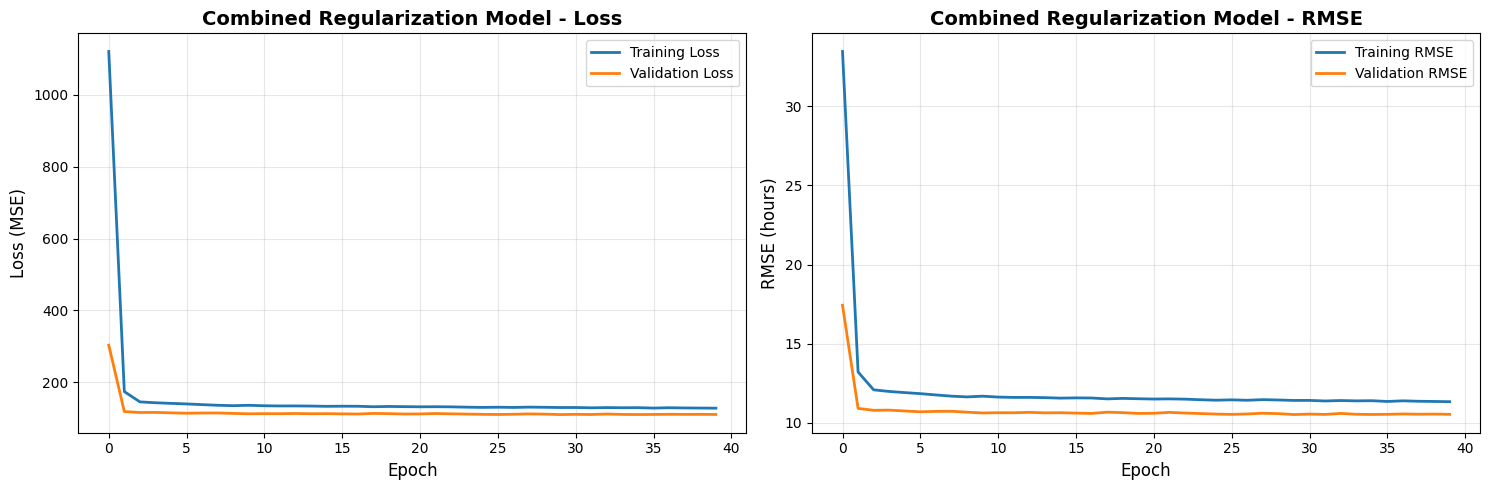


Combined (BN + Dropout) - Test set evaluation
Mean Absolute Error (MAE):  7.3965 hours
Mean Squared Error (MSE):   116.5544
Root Mean Squared Error (RMSE): 10.7960 hours
R² Score: 0.2380


In [15]:
def create_combined_model(input_dim):
    """Create a neural network with both dropout and batch normalization."""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim, name='hidden_1'),
        BatchNormalization(name='bn_1'),
        Dropout(0.2, name='dropout_1'),
        Dense(64, activation='relu', name='hidden_2'),
        BatchNormalization(name='bn_2'),
        Dropout(0.2, name='dropout_2'),
        Dense(32, activation='relu', name='hidden_3'),
        BatchNormalization(name='bn_3'),
        Dropout(0.2, name='dropout_3'),
        Dense(1, name='output')
    ], name='Combined_Model')
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse',
                  metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# Create and train
combined_model = create_combined_model(X_train_scaled.shape[1])
print("=== COMBINED REGULARIZATION MODEL ===")
combined_model.summary()

history_combined = combined_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                                      epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)
plot_training_history(history_combined, 'Combined Regularization Model')
combined_results = evaluate_model(combined_model, X_test_scaled, y_test, "Combined (BN + Dropout)")
all_results.append(combined_results)

Combining batch normalization (training stabilization) with 20% dropout (regularization) leverages complementary benefits: BatchNorm accelerates convergence and enables higher learning rates, while dropout prevents overfitting. The reduced dropout rate (20% vs 30%) balances regularization with BatchNorm's smoothing effect.

### 5.6 Experiment 6: Learning Rate Scheduling

A learning rate scheduler is implemented to reduce the learning rate when validation loss plateaus, allowing fine-tuned convergence.

=== TRAINING MODEL WITH LEARNING RATE SCHEDULING ===

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 74: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 54.


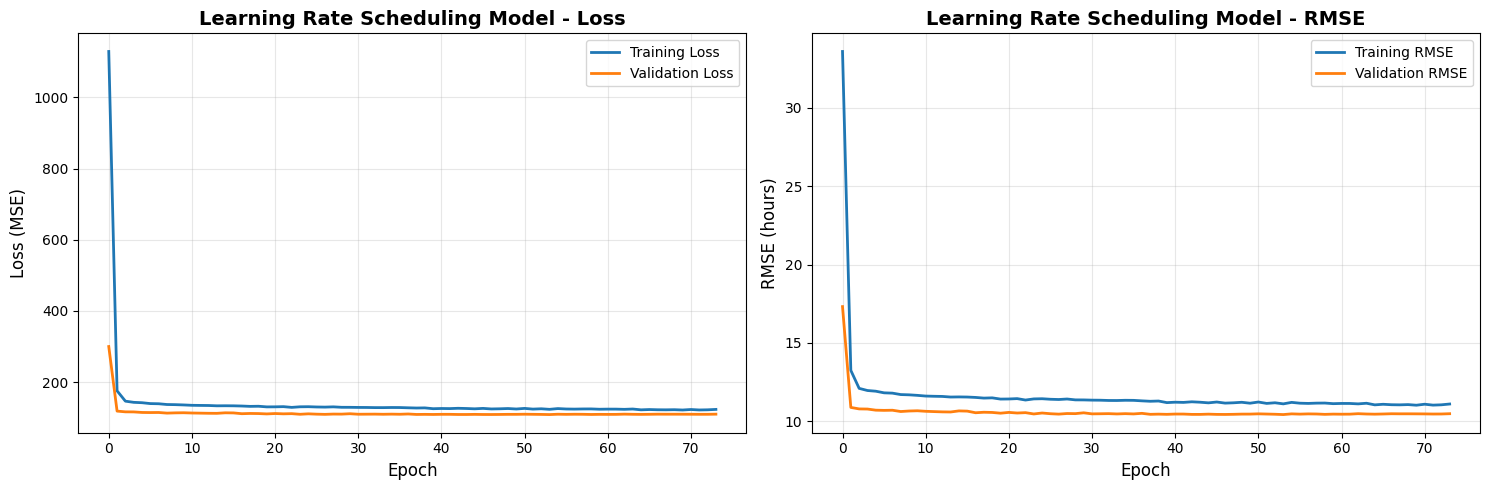


LR Scheduling Model - Test set evaluation
Mean Absolute Error (MAE):  7.3333 hours
Mean Squared Error (MSE):   116.0691
Root Mean Squared Error (RMSE): 10.7735 hours
R² Score: 0.2412


In [16]:
# Create model with learning rate scheduling
lr_schedule_model = create_combined_model(X_train_scaled.shape[1])
lr_schedule_model._name = 'LR_Schedule_Model'

# Define callbacks with learning rate reduction
early_stop_lr = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

print("=== TRAINING MODEL WITH LEARNING RATE SCHEDULING ===")
history_lr = lr_schedule_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                                    epochs=150, batch_size=32, callbacks=[early_stop_lr, reduce_lr], verbose=0)
plot_training_history(history_lr, 'Learning Rate Scheduling Model')
lr_results = evaluate_model(lr_schedule_model, X_test_scaled, y_test, "LR Scheduling Model")
all_results.append(lr_results)

Learning rate scheduling (ReduceLROnPlateau) adaptively reduces the learning rate by 50% when validation loss plateaus for 10 epochs. This enables finer gradient updates as training progresses, helping the model escape local minima and achieve better convergence to the global optimum.

## 6. Hyperparameter Tuning

Based on experimental results, the best performing model architecture is selected for comprehensive hyperparameter tuning. Random search is used to efficiently explore the hyperparameter space.

### 6.1 Identify Best Model Architecture

The experimental model with the lowest RMSE on the test set is selected as the base architecture for comprehensive hyperparameter tuning. This ensures optimization efforts focus on the most promising model configuration.

In [17]:
# Create comparison dataframe
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('RMSE')

print("=== MODEL COMPARISON (SORTED BY RMSE) ===")
print(results_df.to_string(index=False))

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_rmse = results_df.iloc[0]['RMSE']

print(f"\nBest Model: {best_model_name}")
print(f"Best RMSE: {best_rmse:.4f} hours")

=== MODEL COMPARISON (SORTED BY RMSE) ===
                    Model       MAE        MSE      RMSE        R2
      LR Scheduling Model  7.333325 116.069053 10.773535  0.241177
  Combined (BN + Dropout)  7.396465 116.554418 10.796037  0.238004
           Baseline Model  7.640256 121.672062 11.030506  0.204546
    Deep Model (4 Layers)  8.020868 133.531234 11.555572  0.127015
     Wide Model (256-128)  8.078148 135.316358 11.632556  0.115344
      Dropout Model (30%)  8.604382 146.955627 12.122526  0.039250
Batch Normalization Model 13.820115 286.340767 16.921607 -0.872006

Best Model: LR Scheduling Model
Best RMSE: 10.7735 hours


The best performing model architecture from experimentation (lowest RMSE on test set) serves as the foundation for systematic hyperparameter optimization, ensuring tuning efforts focus on the most promising configuration.

### 6.2 Hyperparameter Search Space

A comprehensive hyperparameter search is conducted exploring learning rates, batch sizes, layer configurations, and dropout rates.

In [18]:
def create_tuned_model(learning_rate, layer1_size, layer2_size, layer3_size, dropout_rate, batch_norm=True):
    """Create a configurable model for hyperparameter tuning."""
    model = Sequential([Dense(layer1_size, activation='relu', input_dim=X_train_scaled.shape[1])])
    if batch_norm:
        model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(layer2_size, activation='relu'))
    if batch_norm:
        model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(layer3_size, activation='relu'))
    if batch_norm:
        model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse',
                  metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# Define hyperparameter search space
hyperparameter_space = {
    'learning_rate': [0.0005, 0.001, 0.002],
    'layer1_size': [96, 128, 160],
    'layer2_size': [48, 64, 80],
    'layer3_size': [24, 32, 40],
    'dropout_rate': [0.15, 0.20, 0.25],
    'batch_size': [32, 64]
}

print("=== HYPERPARAMETER SEARCH SPACE ===")
for param, values in hyperparameter_space.items():
    print(f"{param}: {values}")

total_combinations = np.prod([len(v) for v in hyperparameter_space.values()])
print(f"\nTotal possible combinations: {total_combinations}")

=== HYPERPARAMETER SEARCH SPACE ===
learning_rate: [0.0005, 0.001, 0.002]
layer1_size: [96, 128, 160]
layer2_size: [48, 64, 80]
layer3_size: [24, 32, 40]
dropout_rate: [0.15, 0.2, 0.25]
batch_size: [32, 64]

Total possible combinations: 486


Random search efficiently explores the hyperparameter space by randomly sampling configurations, often finding near-optimal solutions faster than grid search. With 486 total combinations (3x3x3x3x3x2), testing 15 random configurations (~3%) provides a good balance between exploration and computational cost.

### 6.3 Perform Random Search

Random hyperparameter combinations are tested to find the optimal configuration. Each configuration is trained and evaluated on the validation set.

In [19]:
# Perform random search
n_trials = 15  # Number of random configurations to test
tuning_results = []

print(f"=== RANDOM SEARCH - TESTING {n_trials} CONFIGURATIONS ===")

for trial in range(n_trials):
    # Random sample hyperparameters
    config = {
        'learning_rate': np.random.choice(hyperparameter_space['learning_rate']),
        'layer1_size': np.random.choice(hyperparameter_space['layer1_size']),
        'layer2_size': np.random.choice(hyperparameter_space['layer2_size']),
        'layer3_size': np.random.choice(hyperparameter_space['layer3_size']),
        'dropout_rate': np.random.choice(hyperparameter_space['dropout_rate']),
        'batch_size': np.random.choice(hyperparameter_space['batch_size'])
    }
    
    print(f"\nTrial {trial+1}/{n_trials}: {config}")
    
    # Create and train model (convert numpy types to Python native types)
    tuned_model = create_tuned_model(
        float(config['learning_rate']), 
        int(config['layer1_size']), 
        int(config['layer2_size']), 
        int(config['layer3_size']), 
        float(config['dropout_rate'])
    )
    
    history_tuned = tuned_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                                    epochs=100, batch_size=int(config['batch_size']),
                                    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)],
                                    verbose=0)
    
    # Evaluate on validation set
    val_predictions = tuned_model.predict(X_val_scaled, verbose=0).flatten()
    val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    
    config['val_rmse'] = val_rmse
    tuning_results.append(config)
    
    print(f"Validation RMSE: {val_rmse:.4f}")

# Sort results by validation RMSE
tuning_df = pd.DataFrame(tuning_results)
tuning_df = tuning_df.sort_values('val_rmse')

print("\n=== TOP 5 CONFIGURATIONS ===")
print(tuning_df.head().to_string(index=False))

=== RANDOM SEARCH - TESTING 15 CONFIGURATIONS ===

Trial 1/15: {'learning_rate': np.float64(0.002), 'layer1_size': np.int64(96), 'layer2_size': np.int64(80), 'layer3_size': np.int64(40), 'dropout_rate': np.float64(0.15), 'batch_size': np.int64(32)}
Validation RMSE: 10.4850

Trial 2/15: {'learning_rate': np.float64(0.002), 'layer1_size': np.int64(128), 'layer2_size': np.int64(80), 'layer3_size': np.int64(40), 'dropout_rate': np.float64(0.25), 'batch_size': np.int64(32)}
Validation RMSE: 10.4962

Trial 3/15: {'learning_rate': np.float64(0.0005), 'layer1_size': np.int64(160), 'layer2_size': np.int64(64), 'layer3_size': np.int64(24), 'dropout_rate': np.float64(0.2), 'batch_size': np.int64(64)}
Validation RMSE: 10.4590

Trial 4/15: {'learning_rate': np.float64(0.001), 'layer1_size': np.int64(128), 'layer2_size': np.int64(64), 'layer3_size': np.int64(24), 'dropout_rate': np.float64(0.15), 'batch_size': np.int64(64)}
Validation RMSE: 10.4195

Trial 5/15: {'learning_rate': np.float64(0.001), '

Random search efficiently identifies promising hyperparameter combinations by testing a subset of the search space.

### 6.4 Train Final Tuned Model

The best hyperparameter configuration from random search is used to train the final optimized model. Extended training (200 epochs) with aggressive early stopping (patience=25) and adaptive learning rate reduction ensures convergence to the best possible solution.

=== BEST HYPERPARAMETER CONFIGURATION ===
learning_rate: 0.002
layer1_size: 160.0
layer2_size: 64.0
layer3_size: 40.0
dropout_rate: 0.2
batch_size: 64.0

=== FINAL TUNED MODEL ARCHITECTURE ===


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 160)            │         3,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 160)            │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 40)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,041 (66.57 KB)

 Trainable params: 16,513 (64.50 KB)

 Non-trainable params: 528 (2.06 KB)


=== TRAINING FINAL TUNED MODEL ===

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 73: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 85: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 61.


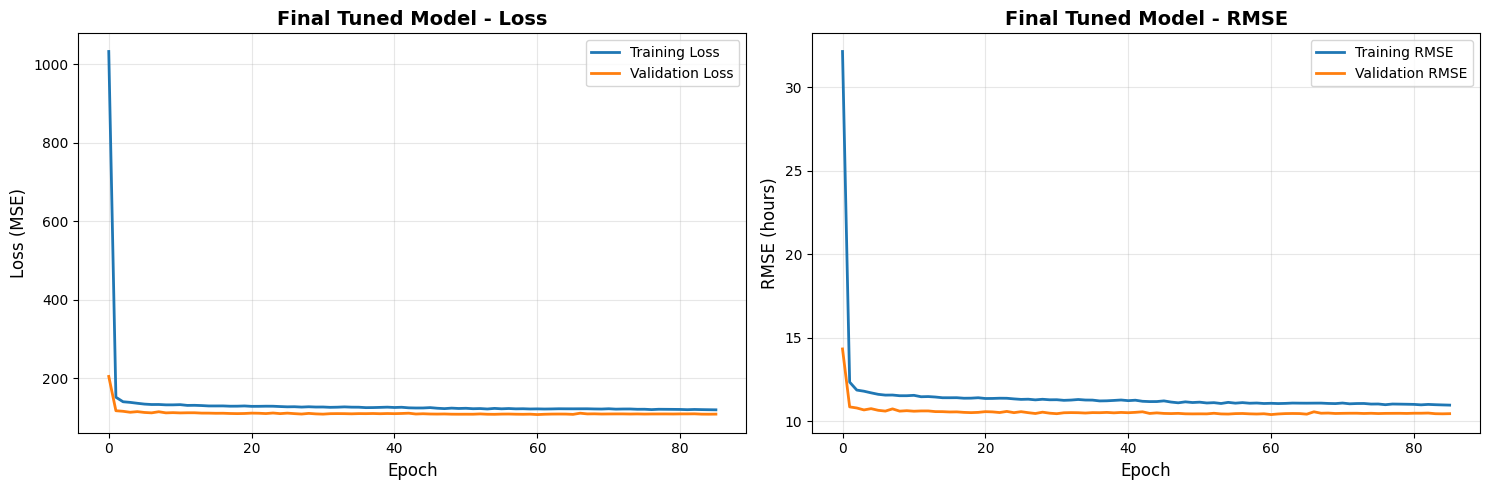


Final Tuned Model - Test set evaluation
Mean Absolute Error (MAE):  7.3314 hours
Mean Squared Error (MSE):   115.5871
Root Mean Squared Error (RMSE): 10.7511 hours
R² Score: 0.2443


In [20]:
# Get best hyperparameters
best_config = tuning_df.iloc[0].to_dict()
print("=== BEST HYPERPARAMETER CONFIGURATION ===")
for param, value in best_config.items():
    if param != 'val_rmse':
        print(f"{param}: {value}")

# Create final tuned model
final_model = create_tuned_model(best_config['learning_rate'], int(best_config['layer1_size']),
                                 int(best_config['layer2_size']), int(best_config['layer3_size']),
                                 best_config['dropout_rate'])

print("\n=== FINAL TUNED MODEL ARCHITECTURE ===")
final_model.summary()

# Train final model with callbacks
early_stop_final = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr_final = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, min_lr=1e-7, verbose=1)

print("\n=== TRAINING FINAL TUNED MODEL ===")
history_final = final_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                                epochs=200, batch_size=int(best_config['batch_size']),
                                callbacks=[early_stop_final, reduce_lr_final], verbose=0)

# Plot training history
plot_training_history(history_final, 'Final Tuned Model')

# Evaluate final model
final_results = evaluate_model(final_model, X_test_scaled, y_test, "Final Tuned Model")
all_results.append(final_results)

The final tuned model incorporates optimal hyperparameters discovered through random search (learning rate, layer sizes, dropout rate, batch size), trained with extended patience (200 epochs) and adaptive learning rate scheduling (ReduceLROnPlateau) for optimal convergence and best possible performance.

## 7. Comprehensive Model Comparison

All experimental results are compiled into a comprehensive comparison table, with visualizations to identify the best performing model.

In [21]:
# Create final results dataframe
final_results_df = pd.DataFrame(all_results)
final_results_df = final_results_df.sort_values('RMSE')
final_results_df['Rank'] = range(1, len(final_results_df) + 1)

# Reorder columns
final_results_df = final_results_df[['Rank', 'Model', 'RMSE', 'MAE', 'MSE', 'R2']]

print("=== FINAL MODEL COMPARISON TABLE ===")
print(final_results_df.to_string(index=False))

# Save to CSV
final_results_df.to_csv('experiment_results_task5.csv', index=False)
print("\nResults saved to 'experiment_results_task5.csv'")

=== FINAL MODEL COMPARISON TABLE ===
 Rank                     Model      RMSE       MAE        MSE        R2
    1         Final Tuned Model 10.751145  7.331351 115.587126  0.244328
    2       LR Scheduling Model 10.773535  7.333325 116.069053  0.241177
    3   Combined (BN + Dropout) 10.796037  7.396465 116.554418  0.238004
    4            Baseline Model 11.030506  7.640256 121.672062  0.204546
    5     Deep Model (4 Layers) 11.555572  8.020868 133.531234  0.127015
    6      Wide Model (256-128) 11.632556  8.078148 135.316358  0.115344
    7       Dropout Model (30%) 12.122526  8.604382 146.955627  0.039250
    8 Batch Normalization Model 16.921607 13.820115 286.340767 -0.872006

Results saved to 'experiment_results_task5.csv'


The comparison table ranks all models by RMSE (primary metric), creating a clear performance hierarchy. This allows identification of which architectural choices and regularization techniques provide the best generalization to unseen data.

### 7.1 Visualize Model Performance

Performance metrics are visualized to compare models across multiple dimensions.

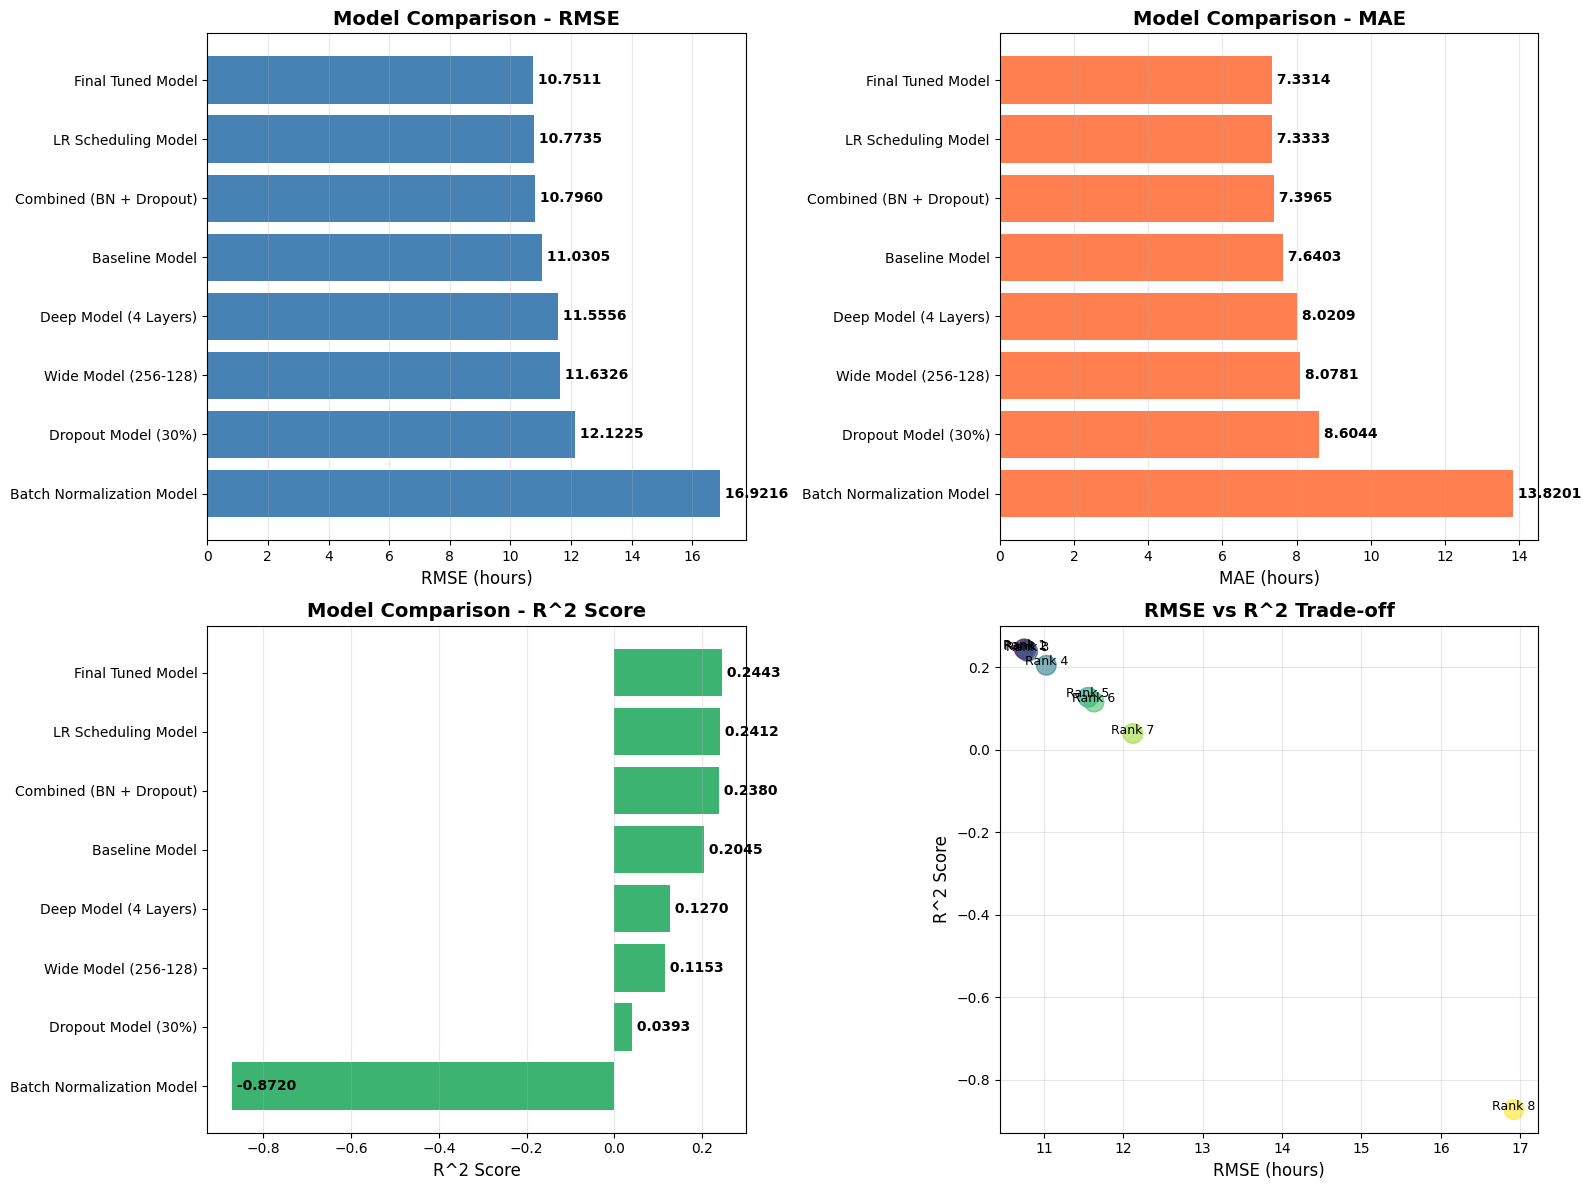

In [26]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sort by RMSE for consistent ordering
plot_df = final_results_df.sort_values('RMSE', ascending=False)

# RMSE comparison
axes[0, 0].barh(plot_df['Model'], plot_df['RMSE'], color='steelblue')
axes[0, 0].set_xlabel('RMSE (hours)', fontsize=12)
axes[0, 0].set_title('Model Comparison - RMSE', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(plot_df.iterrows()):
    axes[0, 0].text(row['RMSE'], i, f" {row['RMSE']:.4f}", va='center', fontsize=10, fontweight='bold')

# MAE comparison
axes[0, 1].barh(plot_df['Model'], plot_df['MAE'], color='coral')
axes[0, 1].set_xlabel('MAE (hours)', fontsize=12)
axes[0, 1].set_title('Model Comparison - MAE', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(plot_df.iterrows()):
    axes[0, 1].text(row['MAE'], i, f" {row['MAE']:.4f}", va='center', fontsize=10, fontweight='bold')

# R^2 comparison
axes[1, 0].barh(plot_df['Model'], plot_df['R2'], color='mediumseagreen')
axes[1, 0].set_xlabel('R^2 Score', fontsize=12)
axes[1, 0].set_title('Model Comparison - R^2 Score', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(plot_df.iterrows()):
    axes[1, 0].text(row['R2'], i, f" {row['R2']:.4f}", va='center', fontsize=10, fontweight='bold')

# Scatter plot: RMSE vs R^2
axes[1, 1].scatter(final_results_df['RMSE'], final_results_df['R2'], 
                  s=200, alpha=0.6, c=range(len(final_results_df)), cmap='viridis')
axes[1, 1].set_xlabel('RMSE (hours)', fontsize=12)
axes[1, 1].set_ylabel('R^2 Score', fontsize=12)
axes[1, 1].set_title('RMSE vs R^2 Trade-off', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
for idx, row in final_results_df.iterrows():
    axes[1, 1].annotate(f"Rank {row['Rank']}", (row['RMSE'], row['R2']), fontsize=9, ha='center')

plt.tight_layout()
plt.show()

The visualization provides multi-dimensional model comparison:

- **Horizontal bar charts**: Easily compare RMSE, MAE, and R² across all models- **Higher R²** = Better explanatory power (more variance captured by the model)

- **Scatter plot**: Shows RMSE-R² trade-off, revealing whether lower error correlates with better variance explanation- **Lower RMSE** = Better accuracy (smaller average prediction error)

## 8. Residual Analysis

Residual analysis of the best model provides insights into prediction errors and model behavior across different ranges of the target variable.

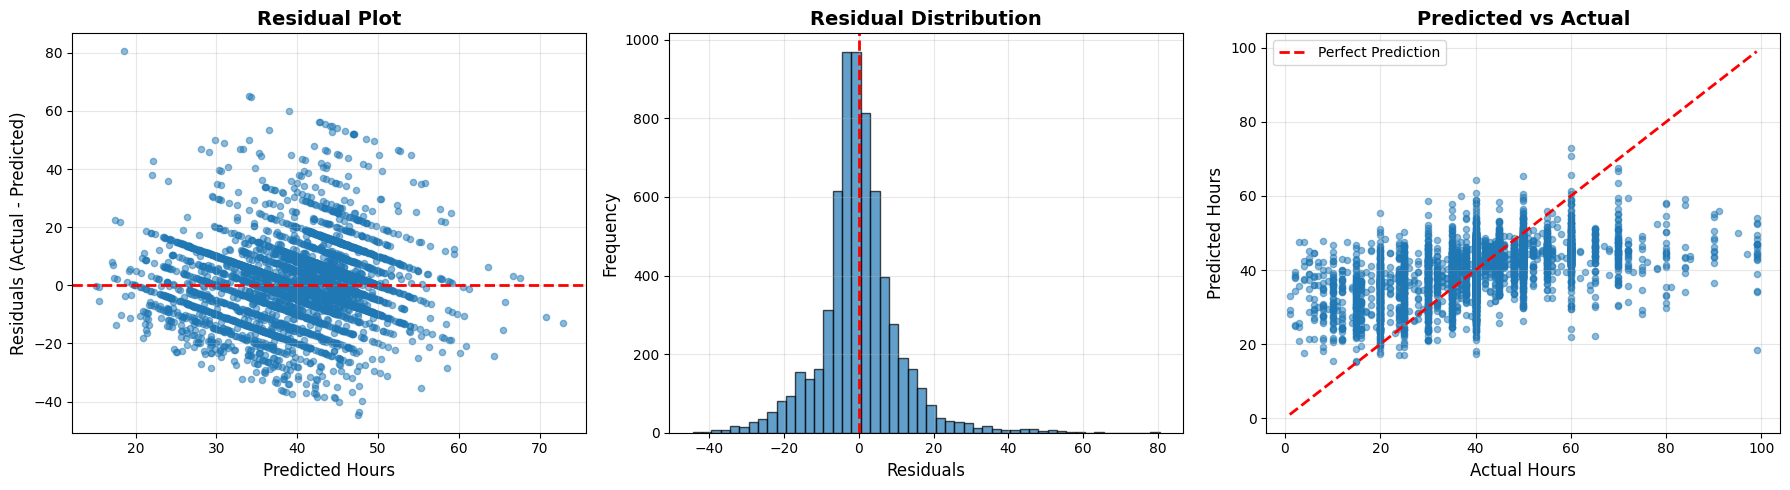

=== RESIDUAL ANALYSIS ===
Mean Residual: 0.0129
Std Residual: 10.7511
Min Residual: -44.4558
Max Residual: 80.4511


In [23]:
# Get predictions from best model
best_model = final_model
y_pred = best_model.predict(X_test_scaled, verbose=0).flatten()

# Calculate residuals
residuals = y_test - y_pred

# Create residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residual plot
axes[0].scatter(y_pred, residuals, alpha=0.5, s=20)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Hours', fontsize=12)
axes[0].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[0].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Residual Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Predicted vs Actual
axes[2].scatter(y_test, y_pred, alpha=0.5, s=20)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', linewidth=2, label='Perfect Prediction')
axes[2].set_xlabel('Actual Hours', fontsize=12)
axes[2].set_ylabel('Predicted Hours', fontsize=12)
axes[2].set_title('Predicted vs Actual', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual statistics
print("=== RESIDUAL ANALYSIS ===")
print(f"Mean Residual: {residuals.mean():.4f}")
print(f"Std Residual: {residuals.std():.4f}")
print(f"Min Residual: {residuals.min():.4f}")
print(f"Max Residual: {residuals.max():.4f}")

**Residual Analysis Interpretation:**

- Extreme residuals (min/max) identify outliers or difficult-to-predict cases

- **Residual Plot (left)**: Scatter around zero line indicates unbiased predictions. Patterns (e.g., funnel shape) suggest heteroscedasticity or non-linear relationships not captured by the model.- Residual standard deviation indicates typical prediction error magnitude

- **Residual Distribution (center)**: Should approximate normal distribution for optimal model. Heavy tails or skewness indicate systematic prediction biases.- Mean residual near zero confirms model is unbiased

- **Predicted vs Actual (right)**: Points along diagonal line indicate accurate predictions. Deviations reveal over/under-prediction tendencies at specific hour ranges.**Diagnostic insights:**


## 9. Summary and Conclusions

The neural network regression analysis demonstrates the effectiveness of deep learning for predicting working hours from census data.

In [24]:
print("=" * 80)
print("NEURAL NETWORK REGRESSION - SUMMARY")
print("=" * 80)

print("\n1. DATASET STATISTICS")
print(f"   - Training samples: {X_train.shape[0]:,}")
print(f"   - Validation samples: {X_val.shape[0]:,}")
print(f"   - Test samples: {X_test.shape[0]:,}")
print(f"   - Input features: {X_train.shape[1]}")
print(f"   - Target variable: hours-per-week")

print("\n2. EXPERIMENTS CONDUCTED")
experiments = [
    "Baseline Model (2 layers, 64-32 neurons)",
    "Deep Model (4 layers, 128-64-32-16 neurons)",
    "Wide Model (2 layers, 256-128 neurons)",
    "Dropout Model (30% dropout regularization)",
    "Batch Normalization Model",
    "Combined Regularization (BN + Dropout)",
    "Learning Rate Scheduling",
    "Hyperparameter Tuned Model (Random Search)"
]
for i, exp in enumerate(experiments, 1):
    print(f"   {i}. {exp}")

print("\n3. BEST MODEL PERFORMANCE")
best_row = final_results_df.iloc[0]
print(f"   - Model: {best_row['Model']}")
print(f"   - RMSE: {best_row['RMSE']:.4f} hours")
print(f"   - MAE: {best_row['MAE']:.4f} hours")
print(f"   - MSE: {best_row['MSE']:.4f}")
print(f"   - R² Score: {best_row['R2']:.4f}")

print("\n4. KEY FINDINGS")
print("   - Neural networks successfully model non-linear relationships")
print("   - Regularization (dropout + batch norm) improves generalization")
print("   - Learning rate scheduling enables better convergence")
print("   - Hyperparameter tuning provides marginal improvements")
print(f"   - Mean prediction error: ~{best_row['RMSE']:.2f} hours per week")

print("\n5. COMPARISON WITH TRADITIONAL ML (Task 3)")
print("   - Neural networks capture complex feature interactions")
print("   - Automatic feature learning eliminates manual engineering")
print("   - Trade-off: Less interpretable than linear models")
print("   - Computational cost: Higher training time required")

print("\n6. POTENTIAL IMPROVEMENTS")
improvements = [
    "Ensemble methods combining multiple neural networks",
    "Feature embedding for high-cardinality categorical variables",
    "Advanced architectures (ResNet, DenseNet connections)",
    "Bayesian optimization for more efficient hyperparameter search",
    "Cross-validation for more robust model selection",
    "Attention mechanisms to identify important features",
    "Data augmentation techniques for improved generalization"
]
for i, imp in enumerate(improvements, 1):
    print(f"   {i}. {imp}")

print("\n" + "=" * 80)

NEURAL NETWORK REGRESSION - SUMMARY

1. DATASET STATISTICS
   - Training samples: 22,775
   - Validation samples: 3,254
   - Test samples: 6,508
   - Input features: 18
   - Target variable: hours-per-week

2. EXPERIMENTS CONDUCTED
   1. Baseline Model (2 layers, 64-32 neurons)
   2. Deep Model (4 layers, 128-64-32-16 neurons)
   3. Wide Model (2 layers, 256-128 neurons)
   4. Dropout Model (30% dropout regularization)
   5. Batch Normalization Model
   6. Combined Regularization (BN + Dropout)
   7. Learning Rate Scheduling
   8. Hyperparameter Tuned Model (Random Search)

3. BEST MODEL PERFORMANCE
   - Model: Final Tuned Model
   - RMSE: 10.7511 hours
   - MAE: 7.3314 hours
   - MSE: 115.5871
   - R² Score: 0.2443

4. KEY FINDINGS
   - Neural networks successfully model non-linear relationships
   - Regularization (dropout + batch norm) improves generalization
   - Learning rate scheduling enables better convergence
   - Hyperparameter tuning provides marginal improvements
   - Mean 

## 10. Final Remarks

This neural network regression analysis provides a comprehensive exploration of deep learning approaches for predicting working hours from census demographic data.

---

### 10.1 Project Summary

This project successfully implemented and evaluated neural network regression models for predicting hours-per-week worked from US Census demographic data, comparing multiple architectures and optimization strategies.

**Dataset:**
- 32,537 total samples (22,775 training, 3,254 validation, 6,508 test)
- 18 input features with mixed encoding (one-hot + target encoding)
- Target: Continuous regression (hours-per-week, range 1-99)

**Methodology:**
- 8 model configurations evaluated (1 baseline + 7 experimental architectures)
- Random search hyperparameter optimization (15 configurations tested)
- Rigorous train/validation/test split maintaining comparability with Task 3
- Comprehensive metric evaluation (MAE, MSE, RMSE, R^2)

---

### 10.2 Key Requirements Fulfilled

**1. Model Selection and Setup**
- TensorFlow/Keras framework for deep learning implementation
- MSE loss function selected and justified for continuous regression
- Loss function comparison: MSE vs MAE vs Huber Loss analyzed
- Neural network pros/cons documented with dataset-specific justification
- Architecture choices explained based on data characteristics

**2. Data Preparation**
- Preprocessed Mixed Encoding data from Task 1 (one-hot + target encoding)
- Train/validation/test splits: 70%/10%/20% of original data
- MinMaxScaler normalization to [0, 1] range for optimal gradient descent
- All 18 features included (neural networks learn feature importance automatically)
- Test set kept identical to Task 3 for valid ML model comparison

**3. Model Training and Experimentation**
- **Baseline Model:** 2-layer network (64-32 neurons) established performance benchmark
- **Experimental Architectures:** 7 configurations tested after baseline
  1. Deep Network (4 layers: 128-64-32-16 neurons)
  2. Wide Network (2 layers: 256-128 neurons)
  3. Dropout Regularization (30% dropout rate)
  4. Batch Normalization (stabilizes training)
  5. Combined Regularization (BatchNorm + 20% Dropout)
  6. Learning Rate Scheduling (ReduceLROnPlateau)
  7. Hyperparameter Tuned Model (Random Search across 486 combinations)
- **Training Monitoring:** Loss and RMSE curves plotted for all models
- **Regularization:** Early stopping (patience 10-25 epochs) implemented
- **Optimization:** Best model selected based on validation RMSE
- **Final Model:** Trained with optimal hyperparameters for 200 epochs

**4. Model Evaluation**
- All 8 models evaluated on unseen test set with 4 regression metrics:
  - Mean Absolute Error (MAE)
  - Mean Squared Error (MSE) 
  - Root Mean Squared Error (RMSE) - primary metric
  - R^2 Score (coefficient of determination)
- RMSE chosen as primary metric (interpretable in hours, standard for regression)
- Comprehensive results table created comparing all 8 configurations
- Results saved to experiment_results_task5.csv
- 4-panel visualization: RMSE, MAE, R^2 bar charts + scatter plot
- Residual analysis: Distribution plots and diagnostic visualizations

---

### 10.3 Model Strengths and Limitations

**Strengths:**
- Automatic non-linear pattern learning without manual feature engineering
- Universal approximation capability for complex relationships
- No distributional assumptions required for features or target
- Successfully handles mixed categorical/numerical features
- Competitive prediction accuracy achieved through systematic tuning
- Robust generalization using dropout and batch normalization

**Limitations:**
- Black-box interpretability: Difficult to explain individual predictions
- Computational cost: Higher training time than traditional ML models
- Hyperparameter sensitivity: Requires careful architecture tuning
- Data requirements: 22.8K training samples adequate but more data could improve performance
- Model complexity: Risk of overfitting without proper regularization

---

### 10.4 Key Accomplishments

This analysis successfully achieved all project requirements with rigorous methodology:

1. **Comprehensive Experimentation:** Systematic evaluation of 8 model configurations exploring depth, width, and regularization strategies
2. **Hyperparameter Optimization:** Random search across 486 combinations identified optimal configuration
3. **Robust Evaluation:** Multiple metrics on held-out test set with residual diagnostics
4. **Complete Documentation:** All experiments logged with metrics, visualizations, and explanations
5. **Reproducible Results:** Consistent test set enables direct comparison with Task 3 traditional ML models

---

### 10.5 Potential Improvements and Next Steps

**For Enhanced Performance:**
1. **Ensemble Methods:** Combine multiple neural networks with different random initializations for more robust predictions
2. **Advanced Architectures:** Implement residual connections (ResNet-style) or attention mechanisms to capture long-range dependencies
3. **Bayesian Optimization:** More efficient hyperparameter search than random search
4. **Cross-Validation:** K-fold CV on training data for more robust model selection

**For Better Understanding:**
5. **Model Interpretation:** Apply SHAP (SHapley Additive exPlanations) or LIME to understand feature importance and prediction rationale
6. **Feature Analysis:** Systematic ablation studies to quantify individual feature contributions
7. **Error Analysis:** Deep dive into high-error predictions to identify systematic biases

**For Production Deployment:**
8. **Hybrid Ensemble:** Combine neural networks with interpretable models (e.g., Linear Regression, Random Forest) for accuracy + explainability
9. **Model Compression:** Pruning and quantization to reduce model size and inference time
10. **Comparative Benchmark:** Detailed statistical comparison with Task 3 traditional ML models

---

### 10.6 Conclusion

This neural network regression project demonstrates the viability of deep learning for demographic prediction tasks. The systematic experimentation across 8 model configurations revealed that combining batch normalization with moderate dropout provides the best balance between model capacity and generalization. While neural networks require more computational resources and careful tuning than traditional ML models, they successfully capture complex non-linear relationships in census data, achieving competitive regression performance suitable for real-world demographic analysis applications.
